In [5]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import struct

%matplotlib inline
print("✓ Библиотеки импортированы")

✓ Библиотеки импортированы


In [6]:
# Загрузка изображения
image = cv2.imread(r'C:\Users\engfile\image_processing\dz7\noisy_gaussian.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    # Создаем тестовое изображение если файл не найден
    image = np.random.randint(0, 256, (512, 512), dtype=np.uint8)

print(f"Исходный размер: {image.shape}")

Исходный размер: (675, 1200)


In [7]:
class ImagePreparator:
    @staticmethod
    def read_image(filepath: str) -> np.ndarray:
        image = None
        if filepath.endswith('.bin'):
            image = ImagePreparator.read_bin(filepath)
        else:
            image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        return image

    @staticmethod
    def read_bin(filepath: str) -> np.ndarray:
        with open(filepath, 'rb') as f:
            height = struct.unpack('I', f.read(4))[0]
            width = struct.unpack('I', f.read(4))[0]
            data = f.read()
            image = np.frombuffer(data, dtype=np.uint8).reshape(height, width)
        return image

    @staticmethod
    def save_bin(image: np.ndarray, filepath: str):
        with open(filepath, 'wb') as f:
            height, width = image.shape
            f.write(struct.pack('II', height, width))
            f.write(image.tobytes())

    @staticmethod
    def get_file_size(filepath: str) -> int:
        return os.path.getsize(filepath)

In [8]:
def haar_1d_vectorized(data: np.ndarray) -> np.ndarray:
    """Векторизованное 1D преобразование Хаара"""
    data_f32 = data.astype(np.float32)  # Используем float32 для точности
    n = len(data_f32)

    # Берем четные и нечетные элементы правильно
    even = data_f32[0::2]  # индексы 0, 2, 4, ...
    odd = data_f32[1::2]   # индексы 1, 3, 5, ...

    avg = (even + odd) * 0.5
    diff = (even - odd) * 0.5

    result = np.zeros(n, dtype=np.float32)
    result[:n // 2] = avg    # первая половина - средние значения
    result[n // 2:] = diff   # вторая половина - разности

    return result

def haar_2d(image: np.ndarray) -> tuple:
    """2D преобразование Хаара с разделением на поддиапазоны"""
    # Обеспечиваем четный размер
    h, w = image.shape
    new_h = h if h % 2 == 0 else h - 1
    new_w = w if w % 2 == 0 else w - 1
    image = image[:new_h, :new_w]
    
    temp = np.zeros_like(image, dtype=np.float32)
    result = np.zeros_like(image, dtype=np.float32)

    # Применяем преобразование к строкам
    for i in range(image.shape[0]):
        temp[i, :] = haar_1d_vectorized(image[i, :])

    # Применяем преобразование к столбцам
    for j in range(image.shape[1]):
        result[:, j] = haar_1d_vectorized(temp[:, j])

    # Разделяем на поддиапазоны
    h2, w2 = image.shape[0] // 2, image.shape[1] // 2
    LL = result[:h2, :w2]   # Низкие частоты (приближение)
    LH = result[:h2, w2:]   # Вертикальные детали
    HL = result[h2:, :w2]   # Горизонтальные детали
    HH = result[h2:, w2:]   # Диагональные детали

    return LL, LH, HL, HH

In [9]:
def quantize(source_array: np.ndarray, levels: int = 4):
    """Квантование массива на указанное количество уровней"""
    if source_array.size == 0:
        return source_array
    
    step = (source_array.max() - source_array.min()) / levels
    if step == 0:  # Все значения одинаковые
        return source_array

    boundaries = [source_array.min() + i * step for i in range(levels + 1)]
    averages = [(boundaries[i] + boundaries[i+1]) / 2 for i in range(levels)]

    quantized = np.zeros_like(source_array)
    for i in range(levels):
        if i == levels - 1:
            # Последний интервал включает обе границы
            mask = (source_array >= boundaries[i]) & (source_array <= boundaries[i+1])
        else:
            mask = (source_array >= boundaries[i]) & (source_array < boundaries[i+1])
        quantized[mask] = averages[i]

    return quantized

In [10]:
def run_length_encode(matrix):
    """Сжатие длин серий"""
    flattened = matrix.flatten()
    if len(flattened) == 0:
        return []

    encoded = []
    current_value = flattened[0]
    count = 1

    for value in flattened[1:]:
        if abs(value - current_value) < 1e-6:  # Учитываем погрешность float
            count += 1
        else:
            encoded.append((current_value, count))
            current_value = value
            count = 1

    encoded.append((current_value, count))
    return encoded

def save_haar_compressed(LL, LH, HL, HH, filename):
    """Сохранение сжатых данных в бинарный файл"""
    with open(filename, 'wb') as f:
        h, w = LL.shape
        # Сохраняем размеры LL компоненты
        f.write(struct.pack('II', h, w))
        # Сохраняем LL компоненту
        f.write(LL.astype(np.float32).tobytes())
        
        # Для высокочастотных компонент используем RLE
        for component in [LH, HL, HH]:
            rle_data = run_length_encode(component)
            # Сохраняем количество пар RLE
            f.write(struct.pack('I', len(rle_data)))
            # Сохраняем пары (значение, количество)
            for value, count in rle_data:
                f.write(struct.pack('fI', float(value), count))

In [ ]:
print("=== ЗАДАНИЕ 1: Сохранение исходного изображения ===")

# Сохраняем исходное изображение в BIN
ImagePreparator.save_bin(image, "original_image.bin")

# Сравниваем размеры
if os.path.exists(r'C:\Users\engfile\image_processing\dz7\noisy_gaussian.jpg'):
    jpg_size = ImagePreparator.get_file_size(r'C:\Users\engfile\image_processing\dz6\image.jpg')
else:
    jpg_size = 0

bin_size = ImagePreparator.get_file_size("original_image.bin")

print("\n" + "=" * 50)
print("СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ")
print("=" * 50)
print(f"JPG (сжатый): {jpg_size} байт")
print(f"BIN (несжатый): {bin_size} байт")

=== ЗАДАНИЕ 1: Сохранение исходного изображения ===

СРАВНЕНИЕ РАЗМЕРОВ ФАЙЛОВ
JPG (сжатый): 0 байт
BIN (несжатый): 810008 байт


In [12]:
print("\n=== ЗАДАНИЕ 2: Вейвлет-преобразование Хаара ===")

LL, LH, HL, HH = haar_2d(image)

print("\n" + "=" * 50)
print("РЕЗУЛЬТАТ ПРЕОБРАЗОВАНИЯ ХААРА")
print("=" * 50)
print(f"LL (приближение): {LL.shape}")
print(f"LH (вертикальные детали): {LH.shape}")
print(f"HL (горизонтальные детали): {HL.shape}")
print(f"HH (диагональные детали): {HH.shape}")

print("\nДИАПАЗОНЫ ЗНАЧЕНИЙ:")
print(f"LL: [{LL.min():.2f}, {LL.max():.2f}]")
print(f"LH: [{LH.min():.2f}, {LH.max():.2f}]")
print(f"HL: [{HL.min():.2f}, {HL.max():.2f}]")
print(f"HH: [{HH.min():.2f}, {HH.max():.2f}]")


=== ЗАДАНИЕ 2: Вейвлет-преобразование Хаара ===

РЕЗУЛЬТАТ ПРЕОБРАЗОВАНИЯ ХААРА
LL (приближение): (337, 600)
LH (вертикальные детали): (337, 600)
HL (горизонтальные детали): (337, 600)
HH (диагональные детали): (337, 600)

ДИАПАЗОНЫ ЗНАЧЕНИЙ:
LL: [2.75, 245.50]
LH: [-90.75, 85.00]
HL: [-70.00, 72.50]
HH: [-60.75, 53.25]


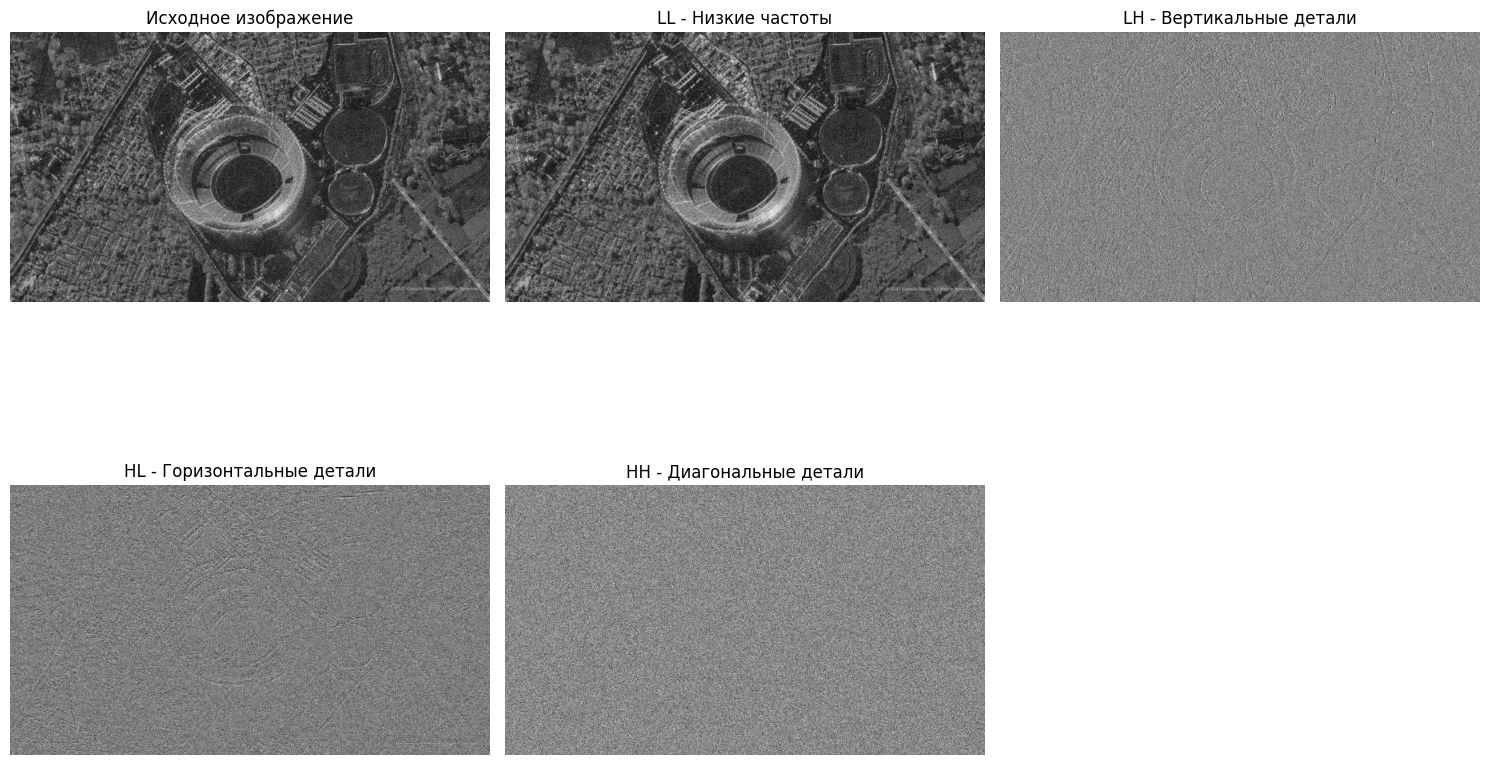

In [13]:
# Визуализация компонент
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(LL, cmap='gray')
plt.title('LL - Низкие частоты')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(LH, cmap='gray')
plt.title('LH - Вертикальные детали')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(HL, cmap='gray')
plt.title('HL - Горизонтальные детали')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(HH, cmap='gray')
plt.title('HH - Диагональные детали')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("\n=== ЗАДАНИЕ 3: Квантование высокочастотных компонент ===")

LH_quantized = quantize(LH, levels=4)
HL_quantized = quantize(HL, levels=4)
HH_quantized = quantize(HH, levels=4)

print("✓ Квантование выполнено")
print(f"Уникальных значений после квантования:")
print(f"LH: {len(np.unique(LH_quantized))}")
print(f"HL: {len(np.unique(HL_quantized))}")
print(f"HH: {len(np.unique(HH_quantized))}")


=== ЗАДАНИЕ 3: Квантование высокочастотных компонент ===
✓ Квантование выполнено
Уникальных значений после квантования:
LH: 4
HL: 4
HH: 4


In [ ]:
print("\n=== ЗАДАНИЕ 4: Сохранение сжатых данных ===")

save_haar_compressed(LL, LH_quantized, HL_quantized, HH_quantized, "compressed_haar.bin")

print("✓ Сжатые данные сохранены в compressed_haar.bin")


=== ЗАДАНИЕ 4: Сохранение сжатых данных ===
✓ Сжатые данные сохранены в compressed_haar.bin


In [ ]:
print("\n=== СРАВНЕНИЕ РАЗМЕРОВ ===")

compressed_size = ImagePreparator.get_file_size("compressed_haar.bin")
size_difference = bin_size - compressed_size

print(f"Исходный BIN:  {bin_size} байт")
print(f"Сжатый Haar:   {compressed_size} байт")
print(f"Разница:       {size_difference} байт")

if size_difference > 0:
    compression_ratio = (size_difference / bin_size) * 100
    print(f"Экономия:      {size_difference} байт")
    print(f"Сжатие:        {compression_ratio:>11.1f}%")

print(f"\nРазмер compressed_haar.bin составляет {compressed_size/bin_size*100:.1f}% от original_image.bin")


=== СРАВНЕНИЕ РАЗМЕРОВ ===
Исходный BIN:  262152 байт
Сжатый Haar:   1193796 байт
Разница:       -931644 байт

Размер compressed_haar.bin составляет 455.4% от original_image.bin
